# Sistema de Prognóstico de Falhas usando Autoencoder e ARIMA

Este notebook implementa um sistema completo de prognóstico de falhas para motores de aeronaves utilizando uma abordagem híbrida que combina:

1. **Autoencoder** para detecção de anomalias e cálculo do Health Index (HI)
2. **Modelo ARIMA** para previsão temporal do HI
3. **Cálculo de probabilidade de falha** baseado em distribuições empíricas

## Fluxo do Processo

- **Etapa 1**: Carregamento e preparação dos dados de sensores
- **Etapa 2**: Treinamento do autoencoder com dados normais
- **Etapa 3**: Cálculo do Health Index (HI) baseado no erro de reconstrução
- **Etapa 4**: Previsão do HI futuro usando ARIMA
- **Etapa 5**: Cálculo da probabilidade de falha usando kernel de resíduos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from scipy.special import inv_boxcox
from scipy.special import boxcox as sp_boxcox
from scipy.stats import boxcox, shapiro, norm
from scipy.special import boxcox as boxcox_scalar

## 1. Carregamento e Preparação dos Dados

Nesta seção, carregamos os dados de sensores do motor (dataset CMAPSS - FD003) e filtramos os dados para o motor específico (unit number = 3). 

Os dados contêm 21 características de sensores (temperaturas, pressões, rotações, etc.) que são usadas para monitorar a saúde do motor.

In [2]:
df = pd.read_excel("data/train_FD003.xlsx")

# assuming your dataframe is named df
df = df[df["unit number"] == 3]

df.drop(columns=["unit number", "cycle", "altitude", "mach_number", "TRA"], inplace=True)
df

,T2,T24,T30,T50,P2,P15,P30,Nf,Nc,epr,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
512,518.67,642.19,1585.49,1401.55,14.62,21.61,554.67,2387.98,9046.11,1.3,...,521.92,2388.00,8136.14,8.4111,0.03,391,2388,100,38.91,23.4896
513,518.67,642.00,1586.60,1393.99,14.62,21.60,553.73,2388.00,9057.38,1.3,...,522.48,2388.02,8139.91,8.3594,0.03,391,2388,100,39.00,23.2964
514,518.67,642.10,1582.43,1394.89,14.62,21.61,555.22,2388.06,9056.81,1.3,...,522.15,2388.06,8139.25,8.4182,0.03,391,2388,100,39.02,23.4047
515,518.67,642.36,1582.80,1396.55,14.62,21.61,554.99,2388.05,9059.65,1.3,...,522.02,2388.00,8138.70,8.3440,0.03,392,2388,100,39.05,23.3914
516,518.67,642.73,1589.39,1397.12,14.62,21.60,554.97,2388.02,9055.29,1.3,...,522.46,2388.02,8132.29,8.3978,0.03,392,2388,100,39.08,23.5019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,518.67,644.03,1602.09,1431.38,14.62,21.61,552.00,2388.25,9089.34,1.3,...,519.76,2388.28,8157.85,8.5216,0.03,396,2388,100,38.36,23.0722
730,518.67,643.52,1598.21,1431.24,14.62,21.61,551.42,2388.21,9085.80,1.3,...,519.73,2388.26,8161.16,8.4929,0.03,397,2388,100,38.31,23.1066
731,518.67,643.67,1606.01,1429.40,14.62,21.61,551.93,2388.27,9094.72,1.3,...,519.50,2388.22,8162.87,8.5492,0.03,395,2388,100,38.33,23.0848
732,518.67,643.97,1598.68,1432.49,14.62,21.61,550.95,2388.23,9088.67,1.3,...,519.99,2388.19,8157.65,8.4921,0.03,396,2388,100,38.41,23.1179


## 2. Seleção de Dados para Treinamento

Selecionamos as primeiras 50 amostras (janela w=50) para treinar o autoencoder. Essas amostras representam o comportamento normal do motor, antes de qualquer degradação significativa.

In [3]:
w = 50
X = df[:w]
X

,T2,T24,T30,T50,P2,P15,P30,Nf,Nc,epr,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
512,518.67,642.19,1585.49,1401.55,14.62,21.61,554.67,2387.98,9046.11,1.3,...,521.92,2388.00,8136.14,8.4111,0.03,391,2388,100,38.91,23.4896
513,518.67,642.00,1586.60,1393.99,14.62,21.60,553.73,2388.00,9057.38,1.3,...,522.48,2388.02,8139.91,8.3594,0.03,391,2388,100,39.00,23.2964
514,518.67,642.10,1582.43,1394.89,14.62,21.61,555.22,2388.06,9056.81,1.3,...,522.15,2388.06,8139.25,8.4182,0.03,391,2388,100,39.02,23.4047
515,518.67,642.36,1582.80,1396.55,14.62,21.61,554.99,2388.05,9059.65,1.3,...,522.02,2388.00,8138.70,8.3440,0.03,392,2388,100,39.05,23.3914
516,518.67,642.73,1589.39,1397.12,14.62,21.60,554.97,2388.02,9055.29,1.3,...,522.46,2388.02,8132.29,8.3978,0.03,392,2388,100,39.08,23.5019
517,518.67,642.23,1572.14,1395.45,14.62,21.61,554.74,2388.01,9053.54,1.3,...,522.53,2388.04,8132.78,8.4483,0.03,391,2388,100,39.10,23.3827
518,518.67,642.13,1578.99,1398.35,14.62,21.61,555.11,2388.06,9063.66,1.3,...,522.84,2388.02,8142.66,8.4093,0.03,391,2388,100,38.99,23.3774
519,518.67,642.48,1584.67,1390.74,14.62,21.61,554.36,2388.04,9048.72,1.3,...,522.31,2388.07,8134.50,8.3606,0.03,393,2388,100,38.91,23.4558
520,518.67,642.08,1583.45,1398.01,14.62,21.61,554.07,2388.03,9052.38,1.3,...,522.44,2387.99,8136.61,8.4011,0.03,392,2388,100,39.02,23.4995
521,518.67,642.09,1593.27,1399.37,14.62,21.61,554.60,2388.01,9055.99,1.3,...,522.41,2388.00,8136.26,8.3841,0.03,392,2388,100,38.99,23.4497


## 3. Divisão dos Dados

Dividimos os dados de treinamento em 80% para treino e 20% para teste. Isso permite avaliar a capacidade do autoencoder de reconstruir dados normais.

In [4]:
# Split into 80% training and 20% testing
X_train, X_test = train_test_split(
    X, test_size=0.2, random_state=42
)


## 4. Definição da Arquitetura do Autoencoder

O autoencoder é uma rede neural que aprende a comprimir e reconstruir os dados de entrada. A arquitetura segue uma estrutura simétrica:

- **Encoder**: Reduz a dimensionalidade de 21 características para um espaço latente de 2 dimensões
- **Decoder**: Reconstrói os dados originais a partir do espaço latente

A função de ativação `tanh` é usada em todas as camadas, e os dados são normalizados no intervalo [-1, 1] para compatibilidade com essa função.

In [5]:
num_columns = df.shape[1]
num_columns

21

## 5. Normalização dos Dados

Os dados são normalizados usando `MinMaxScaler` no intervalo [-1, 1] para compatibilidade com a função de ativação `tanh` do autoencoder. O mesmo scaler será usado posteriormente para normalizar os dados de teste e novos dados.

In [6]:
def prev_fib_smaller(n: int) -> int:
    a, b = 1, 1  # Fibonacci sequence: 1, 1, 2, 3, 5, ...
    while b <= n:
        a, b = b, a + b
    return a  # 'a' will be the last Fibonacci number <= n

num_cols = df.shape[1]
closest_smaller_fib = prev_fib_smaller(num_cols)
print(num_cols, "→", closest_smaller_fib)


21 → 21


## 6. Treinamento do Autoencoder

O autoencoder é treinado para minimizar o erro quadrático médio (MSE) entre os dados de entrada e sua reconstrução. Durante o treinamento, a rede aprende a representar os padrões normais de operação do motor.

Após o treinamento, o modelo é capaz de reconstruir bem dados normais, mas terá dificuldade em reconstruir dados anômalos (indicando degradação).

In [7]:
# Dimensions
input_dim = X_train.shape[1]  
encoding_dim = closest_smaller_fib             



## 7. Cálculo do Health Index (HI)

O Health Index é calculado como o erro quadrático médio (MSE) entre os dados originais e sua reconstrução pelo autoencoder. 

- **HI baixo**: Motor em bom estado (reconstrução precisa)
- **HI alto**: Motor degradado (reconstrução imprecisa)

Os dados restantes (após a janela de treinamento) são usados para calcular o HI ao longo do tempo, mostrando a evolução da degradação do motor.

In [8]:
# -----------------------------------------
# Scale data for tanh (range [-1, 1])
# -----------------------------------------
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 8. Cálculo do HI para Todos os Motores

Nesta seção, calculamos o HI para todos os motores no dataset usando a última amostra de cada motor. Isso permite estabelecer limites globais (mínimo, médio, máximo) que serão usados posteriormente para calcular probabilidades de falha.

In [9]:
# -----------------------------------------
# Define autoencoder
# -----------------------------------------
input_data = Input(shape=(input_dim,))

# ---------- Encoder ----------
x = Dense(13, activation='tanh')(input_data)   # 1st hidden layer → 23
x = Dense(8, activation='tanh')(x)             # 2nd → 8
x = Dense(5, activation='tanh')(x)             # 3rd → 5
x = Dense(3, activation='tanh')(x)             # 4th → 3


# Bottleneck (latent space)
encoded = Dense(2, activation='tanh',
                activity_regularizer=regularizers.l1(1e-5))(x)


# ---------- Decoder ----------
x = Dense(3, activation='tanh')(encoded)       # 5th → 16
x = Dense(5, activation='tanh')(x)             # 6th → 32
x = Dense(8, activation='tanh')(x)             # 7th → 64
x = Dense(13, activation='tanh')(x)            # 8th → 128

# Output layer (reconstruction)
decoded = Dense(input_dim, activation='tanh')(x)  # 9th layer → 21 neurons

# ---------- Models ----------
autoencoder = Model(input_data, decoded)
encoder = Model(input_data, encoded)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()



2025-11-04 16:36:33.230497: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-11-04 16:36:33.230527: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-11-04 16:36:33.230530: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-11-04 16:36:33.230546: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-04 16:36:33.230555: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 13)             │           286 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │            45 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 13)             │           117 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 21)             │           294 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 957 (3.74 KB)

 Trainable params: 957 (3.74 KB)

 Non-trainable params: 0 (0.00 B)

## 9. Preparação dos Dados para Previsão ARIMA

Selecionamos uma janela específica dos dados de HI (amostras 172-202) para treinar o modelo ARIMA. Esta janela representa um período crítico onde a degradação do motor está se acelerando.

O modelo ARIMA será usado para prever o comportamento futuro do HI.

In [10]:
# -----------------------------------------
# Train
# -----------------------------------------
autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=50,
    batch_size=64,
    shuffle=True,
    validation_data=(X_test_scaled, X_test_scaled),
    verbose=1
)

# -----------------------------------------
# Encode and decode
# -----------------------------------------
encoded_data = encoder.predict(X_test_scaled)
decoded_data_scaled = autoencoder.predict(X_test_scaled)

# Inverse transform to original scale
decoded_data = scaler.inverse_transform(decoded_data_scaled)

Epoch 1/50


2025-11-04 16:36:33.726119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.5007 - val_loss: 0.4773
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.4955 - val_loss: 0.4724
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.4908 - val_loss: 0.4679
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.4865 - val_loss: 0.4638
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.4824 - val_loss: 0.4599
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.4786 - val_loss: 0.4561
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.4749 - val_loss: 0.4524
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.4712 - val_loss: 0.4488
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.4675 - val_loss: 0.4452
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.4639 - val_loss: 0.4415
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.4602 - val_loss: 0.4379
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.4565 - val_loss: 0.4342
Epoch 13/50
1/

## 10. Transformação Box-Cox

A transformação Box-Cox é aplicada aos dados de HI para:
- Normalizar a distribuição dos dados
- Estabilizar a variância
- Melhorar a adequação dos dados para modelagem ARIMA

O parâmetro λ (lambda) é escolhido automaticamente para maximizar a normalidade dos dados transformados.

In [11]:
X_new = df[50:]
X_new

,T2,T24,T30,T50,P2,P15,P30,Nf,Nc,epr,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
562,518.67,641.56,1584.51,1400.43,14.62,21.61,554.48,2388.00,9057.17,1.3,...,522.17,2388.02,8140.43,8.4007,0.03,389,2388,100,39.07,23.3006
563,518.67,642.62,1577.99,1393.98,14.62,21.61,554.17,2388.05,9060.80,1.3,...,521.93,2388.00,8133.30,8.3869,0.03,393,2388,100,38.83,23.3713
564,518.67,642.63,1580.73,1397.86,14.62,21.61,554.31,2388.03,9054.24,1.3,...,522.09,2387.97,8135.97,8.4074,0.03,393,2388,100,38.95,23.2626
565,518.67,642.55,1573.72,1403.51,14.62,21.61,554.69,2387.97,9055.48,1.3,...,521.91,2388.01,8134.36,8.4284,0.03,392,2388,100,39.03,23.3574
566,518.67,642.22,1590.22,1395.04,14.62,21.61,554.28,2388.04,9054.15,1.3,...,521.91,2388.04,8136.66,8.4297,0.03,393,2388,100,38.95,23.3864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,518.67,644.03,1602.09,1431.38,14.62,21.61,552.00,2388.25,9089.34,1.3,...,519.76,2388.28,8157.85,8.5216,0.03,396,2388,100,38.36,23.0722
730,518.67,643.52,1598.21,1431.24,14.62,21.61,551.42,2388.21,9085.80,1.3,...,519.73,2388.26,8161.16,8.4929,0.03,397,2388,100,38.31,23.1066
731,518.67,643.67,1606.01,1429.40,14.62,21.61,551.93,2388.27,9094.72,1.3,...,519.50,2388.22,8162.87,8.5492,0.03,395,2388,100,38.33,23.0848
732,518.67,643.97,1598.68,1432.49,14.62,21.61,550.95,2388.23,9088.67,1.3,...,519.99,2388.19,8157.65,8.4921,0.03,396,2388,100,38.41,23.1179


## 11. Teste de Estacionariedade (ADF)

O teste Augmented Dickey-Fuller (ADF) verifica se a série temporal é estacionária. 

- **p-valor < 0.05**: Série estacionária (d = 0)
- **p-valor ≥ 0.05**: Série não estacionária, requer diferenciação (d = 1)

O parâmetro `d` do modelo ARIMA é determinado com base neste teste.

In [12]:
# Scale using the SAME scaler fitted on training data
X_new_scaled = scaler.transform(X_new)

## 12. Seleção Automática do Modelo ARIMA

O `auto_arima` seleciona automaticamente os melhores parâmetros (p, d, q) do modelo ARIMA usando o critério de informação de Akaike (AIC).

- **p**: Ordem do componente autorregressivo (AR)
- **d**: Ordem de diferenciação (já determinado pelo teste ADF)
- **q**: Ordem do componente de média móvel (MA)

O modelo selecionado é então ajustado aos dados transformados.

In [13]:
decoded_new_scaled = autoencoder.predict(X_new_scaled)

# Compute reconstruction error per sample
mse_per_sample_new = np.mean(np.square(X_new_scaled - decoded_new_scaled), axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


## 13. Previsão do HI Futuro

O modelo ARIMA é usado para prever os próximos 20 ciclos do HI. As previsões incluem:

- **Média prevista**: Valor esperado do HI
- **Intervalo de confiança 95%**: Limites inferior e superior da previsão

As previsões são então transformadas de volta ao domínio original usando a transformação inversa de Box-Cox.

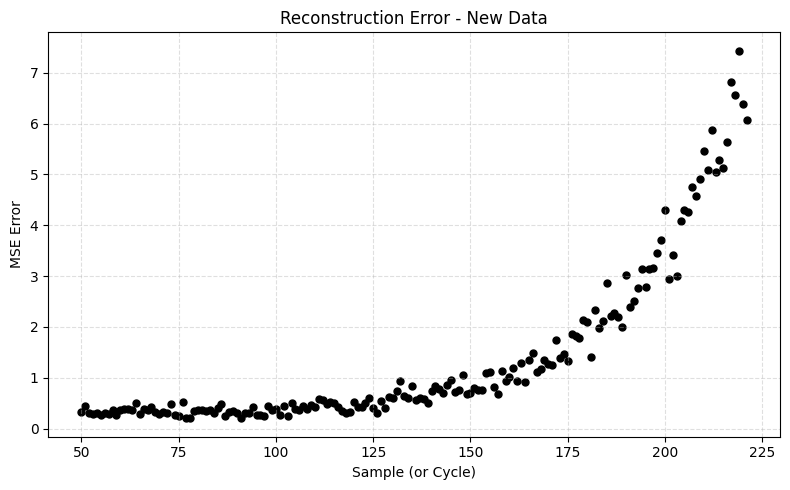

In [14]:
# -----------------------------------------
# STEP 3: Create DataFrame for analysis
# -----------------------------------------


df_mse_new = pd.DataFrame({
    "sample": np.arange(w, len(X_new_scaled) + w),
    "mse": mse_per_sample_new
})



# -----------------------------------------
# STEP 4: Plot reconstruction error
# -----------------------------------------
plt.figure(figsize=(8, 5))
plt.scatter(df_mse_new["sample"], df_mse_new["mse"], color='black', s=25)
plt.title("Reconstruction Error - New Data", fontsize=12)
plt.xlabel("Sample (or Cycle)")
plt.ylabel("MSE Error")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

## 14. Visualização das Previsões

Os gráficos mostram:
- **Dados históricos**: Valores observados do HI
- **Ajuste do modelo**: Valores ajustados pelo ARIMA
- **Previsões futuras**: HI previsto para os próximos ciclos com intervalo de confiança

In [15]:
df = pd.read_excel("data/train_FD003.xlsx")
df.drop(columns=["cycle", "altitude", "mach_number", "TRA"], inplace=True)
df_HI = df.groupby("unit number", group_keys=False).tail(1)
df_HI

,unit number,T2,T24,T30,T50,P2,P15,P30,Nf,Nc,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
258,1,518.67,643.94,1599.54,1434.33,14.62,21.61,551.60,2388.25,9076.30,...,519.44,2388.23,8149.15,8.5313,0.03,398,2388,100,38.35,23.0707
511,2,518.67,643.35,1595.93,1419.99,14.62,21.58,568.81,2388.53,9123.93,...,536.21,2388.51,8190.81,8.2588,0.03,397,2388,100,39.72,23.8854
733,3,518.67,644.23,1598.25,1424.21,14.62,21.61,551.00,2388.20,9088.06,...,520.24,2388.17,8163.26,8.5020,0.03,396,2388,100,38.37,23.1134
1005,4,518.67,643.67,1597.02,1426.14,14.62,21.61,550.74,2388.32,9043.81,...,519.32,2388.34,8116.35,8.5314,0.03,397,2388,100,38.42,23.0814
1218,5,518.67,643.58,1608.57,1437.97,14.62,21.61,551.70,2388.18,9119.82,...,519.86,2388.21,8178.97,8.5134,0.03,397,2388,100,38.23,23.0320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23840,96,518.67,642.87,1604.35,1427.42,14.62,21.58,568.35,2388.51,9118.59,...,535.68,2388.49,8191.36,8.2401,0.03,397,2388,100,39.79,23.7092
24115,97,518.67,643.51,1612.52,1422.49,14.62,21.60,569.25,2388.52,9127.46,...,536.66,2388.53,8190.97,8.2411,0.03,395,2388,100,39.55,23.8974
24422,98,518.67,643.31,1602.30,1425.69,14.62,21.58,568.32,2388.52,9126.21,...,536.03,2388.51,8191.37,8.2294,0.03,397,2388,100,39.58,23.7692
24567,99,518.67,644.15,1603.96,1417.99,14.62,21.61,550.86,2388.29,9070.84,...,519.52,2388.26,8138.32,8.5138,0.03,396,2388,100,38.37,23.1498


## 15. Cálculo da Probabilidade de Falha

A probabilidade de falha é calculada usando um método baseado em kernel de resíduos:

1. **Resíduos do modelo ARIMA**: Diferenças entre valores observados e ajustados
2. **Ajuste do kernel**: Para cada passo de previsão, o kernel de resíduos é ajustado para corresponder à incerteza da previsão ARIMA
3. **Distribuição empírica**: Usa ECDF (Empirical Cumulative Distribution Function) para calcular a probabilidade de o HI exceder o limite de falha

A probabilidade de falha aumenta à medida que o HI previsto se aproxima ou excede os limites estabelecidos.

In [16]:
features = [c for c in df_HI.columns if c != "unit number"]


## 16. Visualização da Probabilidade de Falha

O gráfico final mostra a probabilidade de falha ao longo dos ciclos previstos. Esta informação é crucial para:

- **Manutenção preditiva**: Planejar manutenções antes que a falha ocorra
- **Gestão de risco**: Avaliar quando o motor deve ser removido de serviço
- **Otimização de custos**: Balancear custos de manutenção vs. risco de falha

Uma probabilidade acima de 50% indica alto risco de falha iminente.

In [17]:
# ------------------------------------------------
# Scale data using the same scaler from training
# ------------------------------------------------
X_scaled = scaler.transform(df_HI[features])


In [18]:
# ------------------------------------------------
# Reconstruct and compute per-sample MSE (HI)
# ------------------------------------------------
X_pred = autoencoder.predict(X_scaled, verbose=0)
df_HI["HI_sample"] = np.mean((X_scaled - X_pred)**2, axis=1)


/var/folders/gb/ky0h6snd0sd6dqm0djnndhph0000gn/T/ipykernel_7535/3140546293.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_HI["HI_sample"] = np.mean((X_scaled - X_pred)**2, axis=1)


In [19]:
df_HI["HI_sample"]

258       6.886374
511      52.980107
733       6.079804
1005      7.464429
1218     10.850562
           ...    
23840    50.002364
24115    54.566614
24422    51.382862
24567     6.181889
24719     5.866915
Name: HI_sample, Length: 100, dtype: float64

In [20]:

# ------------------------------------------------
# Compute mean HI per unit (average of its 50 samples)
# ------------------------------------------------
df_hi_units = (
    df_HI.groupby("unit number", as_index=False)["HI_sample"]
          .mean()
          .rename(columns={"HI_sample": "HI_mean"})
)

# ------------------------------------------------
# Compute global thresholds
# ------------------------------------------------
HI_min = df_hi_units["HI_mean"].min()
HI_mean = df_hi_units["HI_mean"].mean()
HI_max = df_hi_units["HI_mean"].max()

print("Global HI thresholds:")
print(f"  Min  = {HI_min:.2f}")
print(f"  Mean = {HI_mean:.2f}")
print(f"  Max  = {HI_max:.2f}")



Global HI thresholds:
  Min  = 5.28
  Mean = 31.13
  Max  = 78.44


In [21]:
subset_df = df_mse_new[(df_mse_new["sample"] >= 172 ) & (df_mse_new["sample"] <= 202)]
subset_df = subset_df.sort_values("sample").reset_index(drop=True)

In [22]:
# --------------------------------------------------
# STEP 1: Prepare data
# --------------------------------------------------
error_series = subset_df["mse"].dropna().reset_index(drop=True).astype(float)

In [23]:
# Ensure all values are positive for Box-Cox
if np.any(error_series <= 0):
    error_series = error_series - np.min(error_series) + 1e-6

# --------------------------------------------------
# STEP 2: Apply Box–Cox transformation
# --------------------------------------------------
transformed, lambda_bc = boxcox(error_series)
print(f"Box–Cox λ = {lambda_bc:.4f}")

Box–Cox λ = 0.1312


In [24]:
# --------------------------------------------------
# STEP 3: ADF test → determine d
# --------------------------------------------------
adf_result = adfuller(transformed)
p_val = adf_result[1]
d = 0 if p_val < 0.05 else 1
print(f"ADF p-value = {p_val:.4f} → d = {d}")

ADF p-value = 0.7610 → d = 1


In [25]:

# --------------------------------------------------
# STEP 4: Auto ARIMA to select p, d, q
# --------------------------------------------------
model_auto = pm.auto_arima(
    transformed,
    start_p=0, start_q=0,
    max_p=5, max_q=5,
    d=d,
    seasonal=False,
    stepwise=True,
    information_criterion='aic',
    suppress_warnings=True
)



p, d, q = model_auto.order
print(f"Selected (p, d, q) = {model_auto.order}")
print(model_auto.summary())

Selected (p, d, q) = (2, 1, 0)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   31
Model:               SARIMAX(2, 1, 0)   Log Likelihood                   9.313
Date:                Tue, 04 Nov 2025   AIC                            -10.627
Time:                        16:36:40   BIC                             -5.022
Sample:                             0   HQIC                            -8.834
                                 - 31                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0688      0.035      1.954      0.051      -0.000       0.138
ar.L1         -0.7912      0.228     -3.470      0.001      -1.238      -0.344
ar.L2         -0.4566

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/pytho

In [26]:
n_forecast = 20
forecast_transformed, conf_int_transformed = model_auto.predict(
    n_periods=n_forecast,
    return_conf_int=True,
    alpha=0.05  # 95% confidence interval
)

# Inverse Box–Cox transformation
forecast = inv_boxcox(forecast_transformed, lambda_bc)
conf_int_lower = inv_boxcox(conf_int_transformed[:, 0], lambda_bc)
conf_int_upper = inv_boxcox(conf_int_transformed[:, 1], lambda_bc)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [27]:
fitted = inv_boxcox(model_auto.predict_in_sample(), lambda_bc)


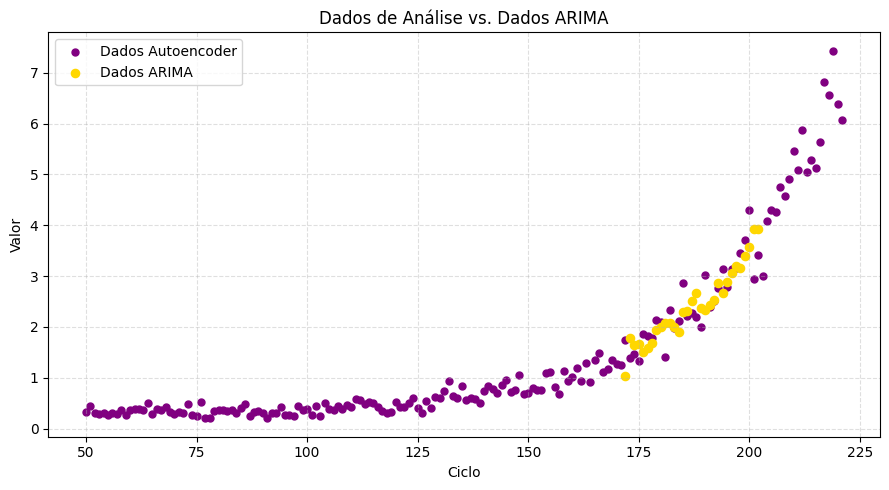

In [28]:
# -----------------------------------------
# Plot both series
# -----------------------------------------
plt.figure(figsize=(9, 5))

# Autoencoder (purple)
plt.scatter(df_mse_new["sample"], df_mse_new["mse"],
            color="purple", label="Dados Autoencoder", s=25)

# ARIMA (yellow)
plt.scatter(subset_df["sample"], fitted,
            color="gold", label="Dados ARIMA", s=35)

# Labels and style
plt.title("Dados de Análise vs. Dados ARIMA", fontsize=12)
plt.xlabel("Ciclo")
plt.ylabel("Valor")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [29]:
# Future sample indices
future_samples = np.arange(203, 203 + n_forecast)
future_samples

array([203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215,
       216, 217, 218, 219, 220, 221, 222])

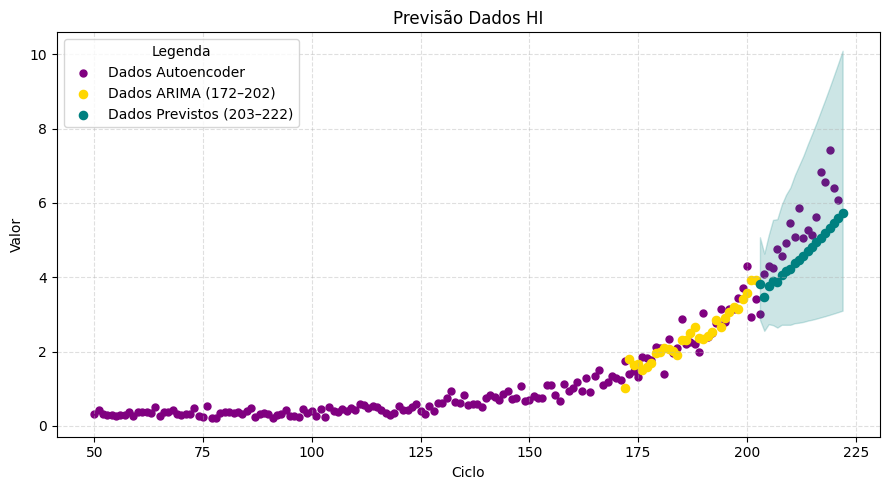

In [30]:
# -----------------------------------------
# Plot all data
# -----------------------------------------
plt.figure(figsize=(9, 5))

# Autoencoder MSE (purple)
plt.scatter(df_mse_new["sample"], df_mse_new["mse"],
            color="purple", label="Dados Autoencoder", s=25)

# ARIMA fitted data (yellow)
plt.scatter(subset_df["sample"], fitted,
            color="gold", label="Dados ARIMA (172–202)", s=35)

# Forecasted values (blue)
plt.scatter(future_samples, forecast,
            color="teal", label="Dados Previstos (203–222)", s=35)

# Confidence interval shading
plt.fill_between(future_samples,
                 conf_int_lower,
                 conf_int_upper,
                 color="teal", alpha=0.2)

# -----------------------------------------
# Labels, legend, and style
# -----------------------------------------
plt.title("Previsão Dados HI", fontsize=12)
plt.xlabel("Ciclo")
plt.ylabel("Valor")
plt.legend(title="Legenda")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


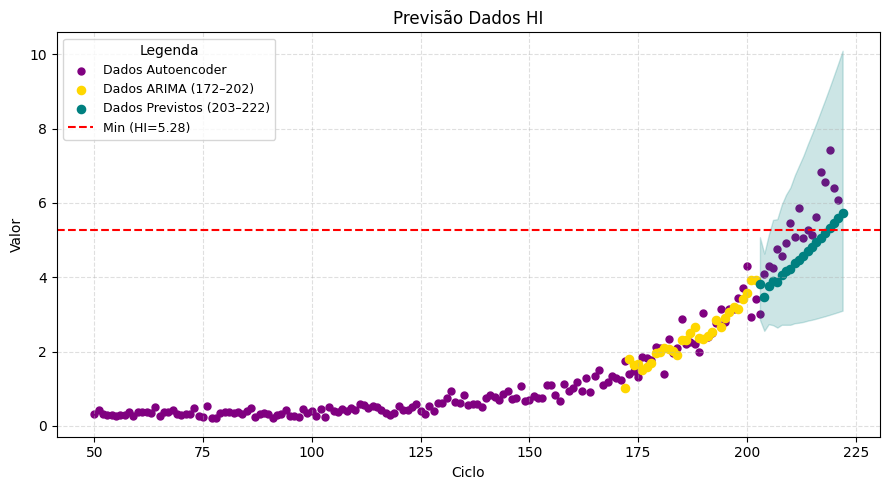

In [31]:
# -----------------------------------------
# Plot all data
# -----------------------------------------
plt.figure(figsize=(9, 5))

# Autoencoder MSE (purple)
plt.scatter(df_mse_new["sample"], df_mse_new["mse"],
            color="purple", label="Dados Autoencoder", s=25)

# ARIMA fitted data (yellow)
plt.scatter(subset_df["sample"], fitted,
            color="gold", label="Dados ARIMA (172–202)", s=35)

# Forecasted values (blue)
plt.scatter(future_samples, forecast,
            color="teal", label="Dados Previstos (203–222)", s=35)

# Confidence interval shading
plt.fill_between(future_samples,
                 conf_int_lower,
                 conf_int_upper,
                 color="teal", alpha=0.2)

# -----------------------------------------
# Add only the Min HI line
# -----------------------------------------
plt.axhline(y=HI_min, color='red', linestyle='--', linewidth=1.5,
            label=f'Min (HI={HI_min:.2f})')

# -----------------------------------------
# Labels, legend, and style
# -----------------------------------------
plt.title("Previsão Dados HI", fontsize=12)
plt.xlabel("Ciclo")
plt.ylabel("Valor")
plt.legend(title="Legenda", loc="upper left", fontsize=9)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [32]:
# ================================================
# STEP 5 — Forecast (in transformed domain) + invert Box–Cox to ORIGINAL domain
# ================================================
n_forecast = 20
fc_bc, ci_bc = model_auto.predict(n_periods=n_forecast, return_conf_int=True, alpha=0.05)

# Back to ORIGINAL HI domain
fc_mean = inv_boxcox(fc_bc, lambda_bc)
fc_lower = inv_boxcox(ci_bc[:, 0], lambda_bc)
fc_upper = inv_boxcox(ci_bc[:, 1], lambda_bc)

# Also get in-sample fitted values in ORIGINAL domain
fitted_bc = model_auto.predict_in_sample()
fitted = inv_boxcox(fitted_bc, lambda_bc)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [33]:
# Series in ORIGINAL (HI) domain
y = subset_df["mse"].dropna().reset_index(drop=True).astype(float)

# Ensure positivity for Box–Cox on the HI series (safety)
if np.any(y <= 0):
    y = y - np.min(y) + 1e-6


In [34]:
# ================================================
# STEP 6 — Compute RESIDUALS in ORIGINAL domain
#           (yellow points are fits; residuals = real - fit)
# ================================================
residuals = y.values - fitted  # ORIGINAL (HI) domain residuals


In [35]:
# STEP 7 — Normality check of residuals
#          If not normal, work in the Box–Cox (transformed) domain for kernel & threshold
# ================================================
sh_stat, sh_p = shapiro(residuals)
print(f"Shapiro-Wilk: stat={sh_stat:.4f}, p={sh_p:.4f}")

use_transformed_kernel = sh_p <= 0.05  # non-normal → transform per PDF guidance

# Prepare domain-specific objects:
if use_transformed_kernel:
    # Residuals must be positive to apply Box–Cox; shift them minimally
    res_shift = residuals - residuals.min() + 1e-6
    res_dom = sp_boxcox(res_shift, lambda_bc)               # kernel domain (transformed)
    # Transform forecasts and threshold to the same domain
    fc_mean_dom  = sp_boxcox(fc_mean,  lambda_bc)
    fc_lower_dom = sp_boxcox(fc_lower, lambda_bc)
    fc_upper_dom = sp_boxcox(fc_upper, lambda_bc)
else:
    # Use ORIGINAL domain directly
    res_dom = residuals
    fc_mean_dom  = fc_mean
    fc_lower_dom = fc_lower
    fc_upper_dom = fc_upper


Shapiro-Wilk: stat=0.9817, p=0.8578


In [36]:
# Threshold in the working domain
HI_thr_dom = sp_boxcox(HI_min, lambda_bc) if use_transformed_kernel else HI_min


In [37]:
from statsmodels.distributions.empirical_distribution import ECDF

# ================================================
# STEP 9 — Build the residual-kernel failure probability per step t
#           Using equations (2)–(5) from your PDF:
#   (2) a_t = (Q_upper,t - Q_lower,t) / (q97.5 - q2.5)
#   (3) b_t = mean_ARIMA,t - a_t * mean_residuals
#   (4) X_i^(t) = a_t * ε_i + b_t
#   (5) P_fail(t) = 1 - ECDF_t(HI_threshold)
# ================================================
q975 = np.percentile(res_dom, 97.5)
q025 = np.percentile(res_dom, 2.5)
res_mean = np.mean(res_dom)

p_fail = []
adj_means = []  # optional: mean of adjusted kernel at each t (should equal fc_mean_dom)
for mean_t, low_t, up_t in zip(fc_mean_dom, fc_lower_dom, fc_upper_dom):
    # --- (2) Scale factor a_t ---
    denom = (q975 - q025) if (q975 - q025) != 0 else 1e-9
    a_t = (up_t - low_t) / denom  # :contentReference[oaicite:2]{index=2}

    # --- (3) Translation b_t to align means ---
    b_t = mean_t - a_t * res_mean  # :contentReference[oaicite:3]{index=3}

    # --- (4) Adjusted kernel for this step ---
    adjusted = a_t * res_dom + b_t  # :contentReference[oaicite:4]{index=4}

    # --- (5) Failure probability against threshold ---
    ecdf = ECDF(adjusted)
    p = 1.0 - ecdf(HI_thr_dom)      # :contentReference[oaicite:5]{index=5}
    p_fail.append(p)
    adj_means.append(np.mean(adjusted))

p_fail = np.array(p_fail)
adj_means = np.array(adj_means)

In [38]:
# ================================================
# STEP 10 — Pack results into a DataFrame (ORIGINAL domain for readability)
# ================================================
future_samples = np.arange(203, 203 + n_forecast)

# If we worked in transformed domain, show ORIGINAL-domain means/intervals for the table/plot:
out_df = pd.DataFrame({
    "sample": future_samples,
    "mean": fc_mean,              # ORIGINAL domain
    "lower_95": fc_lower,         # ORIGINAL domain
    "upper_95": fc_upper,         # ORIGINAL domain
    "p_fail": p_fail              # Probability computed in the correct domain internally
})
print(out_df.head())

   sample      mean  lower_95  upper_95    p_fail
0     203  3.827338  2.854824  5.075722  0.000000
1     204  3.461334  2.554830  4.635227  0.000000
2     205  3.766288  2.733256  5.123013  0.000000
3     206  3.908023  2.709972  5.541929  0.032258
4     207  3.869846  2.643838  5.562548  0.032258


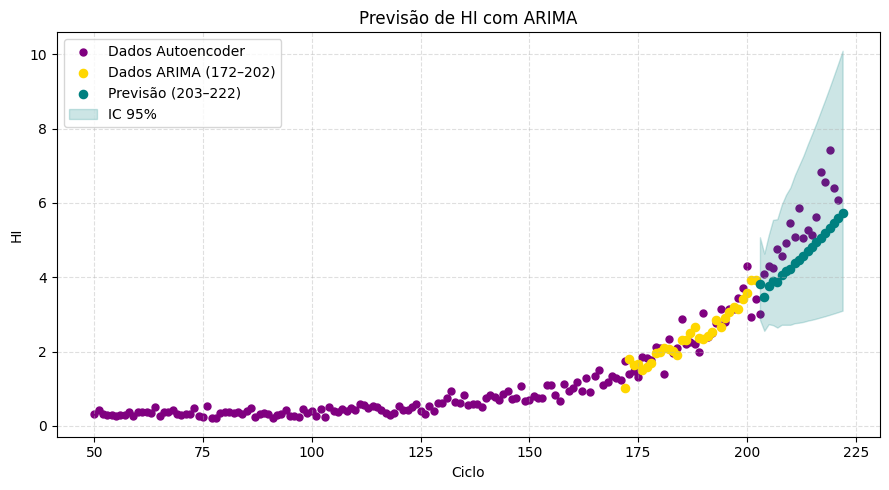

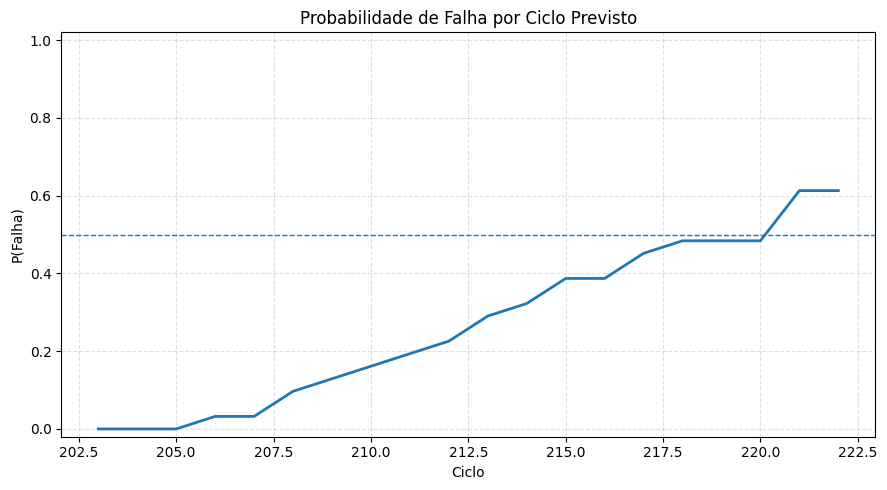

In [39]:
# ================================================
# STEP 11 — Plots
# ================================================
# (A) Observed vs. Fitted vs. Forecast
plt.figure(figsize=(9, 5))
# Raw autoencoder points (full)
plt.scatter(df_mse_new["sample"], df_mse_new["mse"], color="purple", s=25, label="Dados Autoencoder")

# Fitted (yellow) on 172–202
plt.scatter(subset_df["sample"], fitted, color="gold", s=35, label="Dados ARIMA (172–202)")

# Forecast mean and CI (teal)
plt.scatter(future_samples, fc_mean, color="teal", s=35, label="Previsão (203–222)")
plt.fill_between(future_samples, fc_lower, fc_upper, color="teal", alpha=0.2, label="IC 95%")

plt.title("Previsão de HI com ARIMA", fontsize=12)
plt.xlabel("Ciclo"); plt.ylabel("HI")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# (B) Probability of failure curve
plt.figure(figsize=(9, 5))
plt.plot(future_samples, p_fail, linewidth=2)
plt.axhline(0.5, ls="--", lw=1)  # optional reference at 50%
plt.ylim(-0.02, 1.02)
plt.title("Probabilidade de Falha por Ciclo Previsto")
plt.xlabel("Ciclo"); plt.ylabel("P(Falha)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()